In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../../')

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_data, subsample
from model.metrics import psnr, ssim
from model import losses, learners

## Choose Devices

In [2]:
gpu_id = 3
num_cores = 4

In [3]:
torch.cuda.set_device(gpu_id)

To load the patch critic, loading data is necessary. Is there a way to load the model without loading any data (can we save a good critic not as .pth file but as something else)?

## Resnet Feature loss

### Generate Self-Critic

In [4]:
# learn.model_dir = data_pth/f'EM/models/baselines'
# learn.load('emsynth_005_unet.5');
# critic_path = learn.model_dir
# critic_name = f'emsynth_005_unet.5.pkl'
# learn.export(critic_path/critic_name)

# Model

## Initialization

In [5]:
def get_data(data_pth, lr_dir, hr_dir, bs, in_sz, out_sz,
             c_out=3, num_workers=4, noise=None, max_zoom=1.1):
    src = get_src(data_pth, lr_dir, hr_dir)
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=in_sz, resize_method=ResizeMethod.CROP)
            .transform_y(tfms, size=out_sz, resize_method=ResizeMethod.CROP)
            .databunch(bs=bs, num_workers=num_workers)
            .normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

def get_src(data_pth, lr_dir, hr_dir, seed=49):
    hr_tifs = data_pth/f'{hr_dir}'
    lr_tifs = data_pth/f'{lr_dir}'

    def map_to_hr(x):
        return Path(str(hr_tifs/x.relative_to(lr_tifs).with_suffix(".tif")).replace('lr', 'hr'))

    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_rand_pct(seed=seed)
            .label_from_func(map_to_hr))
    return src

In [6]:
nb_name = 'baseline-pretrained-toddler'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_path = data_pth/f'EM/models/self_sv/selfcritic'

# loading 3 rounds of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, c_out=3, max_zoom=6.)
db = subsample(db, seed=42)

In [7]:
# ONLY USE FOR MODEL LOADING
# bs_1 = 8
# size_1 = 512
# db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
#              bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=2.)

In [8]:
x,y = db.one_batch()

In [9]:
y.shape, x.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 3, 128, 128]))

In [10]:
len(db.train_dl)

124

In [11]:
superres_metrics = [F.mse_loss, psnr, ssim]

In [12]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(db, arch, wd=wd, 
                         loss_func=F.mse_loss,
                         metrics=superres_metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_path)
gc.collect()

154

In [13]:
model_path

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/selfcritic')

In [14]:
learn.model_dir = model_path
print(learn.model_dir)
learn.model_dir = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/selfcritic')
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/selfcritic
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/selfcritic


## Load Model (optional)

In [15]:
# learn.model_dir = model_pth
# learn = learn.load(f'{nb_name}.3c')
# load pssr model
# learn.model_dir = data_pth/f'EM/models/feat_loss'
# learn = learn.load('emsynth_005_unet.5')
# learn = learn.load('featureloss-resnet34-pretrained.2b')

### Baseline

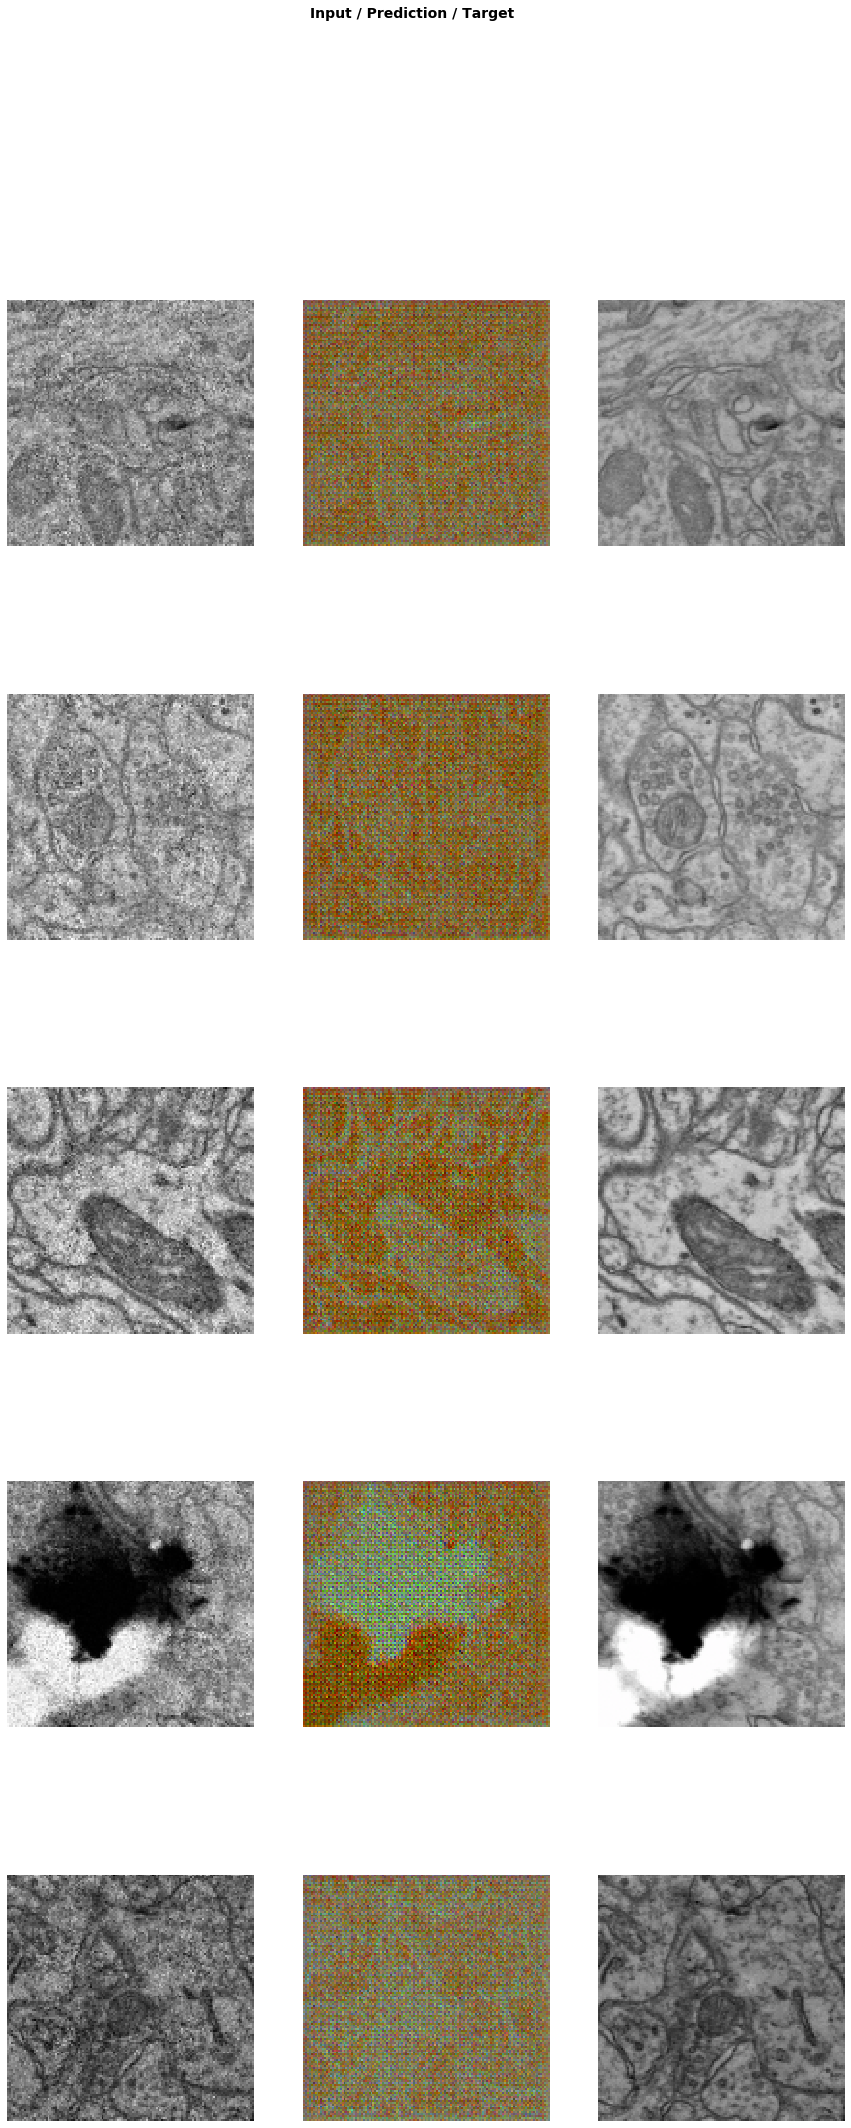

In [16]:
learn.show_results(rows=5, figsize=(15,35))

In [17]:
learn.loss_func = F.mse_loss
learn.loss_func

<function torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='mean')>

## Training

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


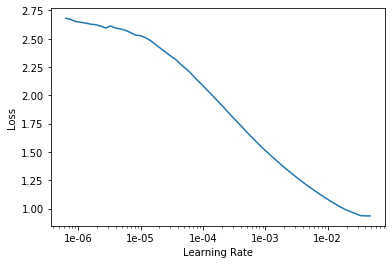

In [19]:
learn.recorder.plot()

### 1a
Freeze + MSE

In [20]:
lr = 3e-4
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

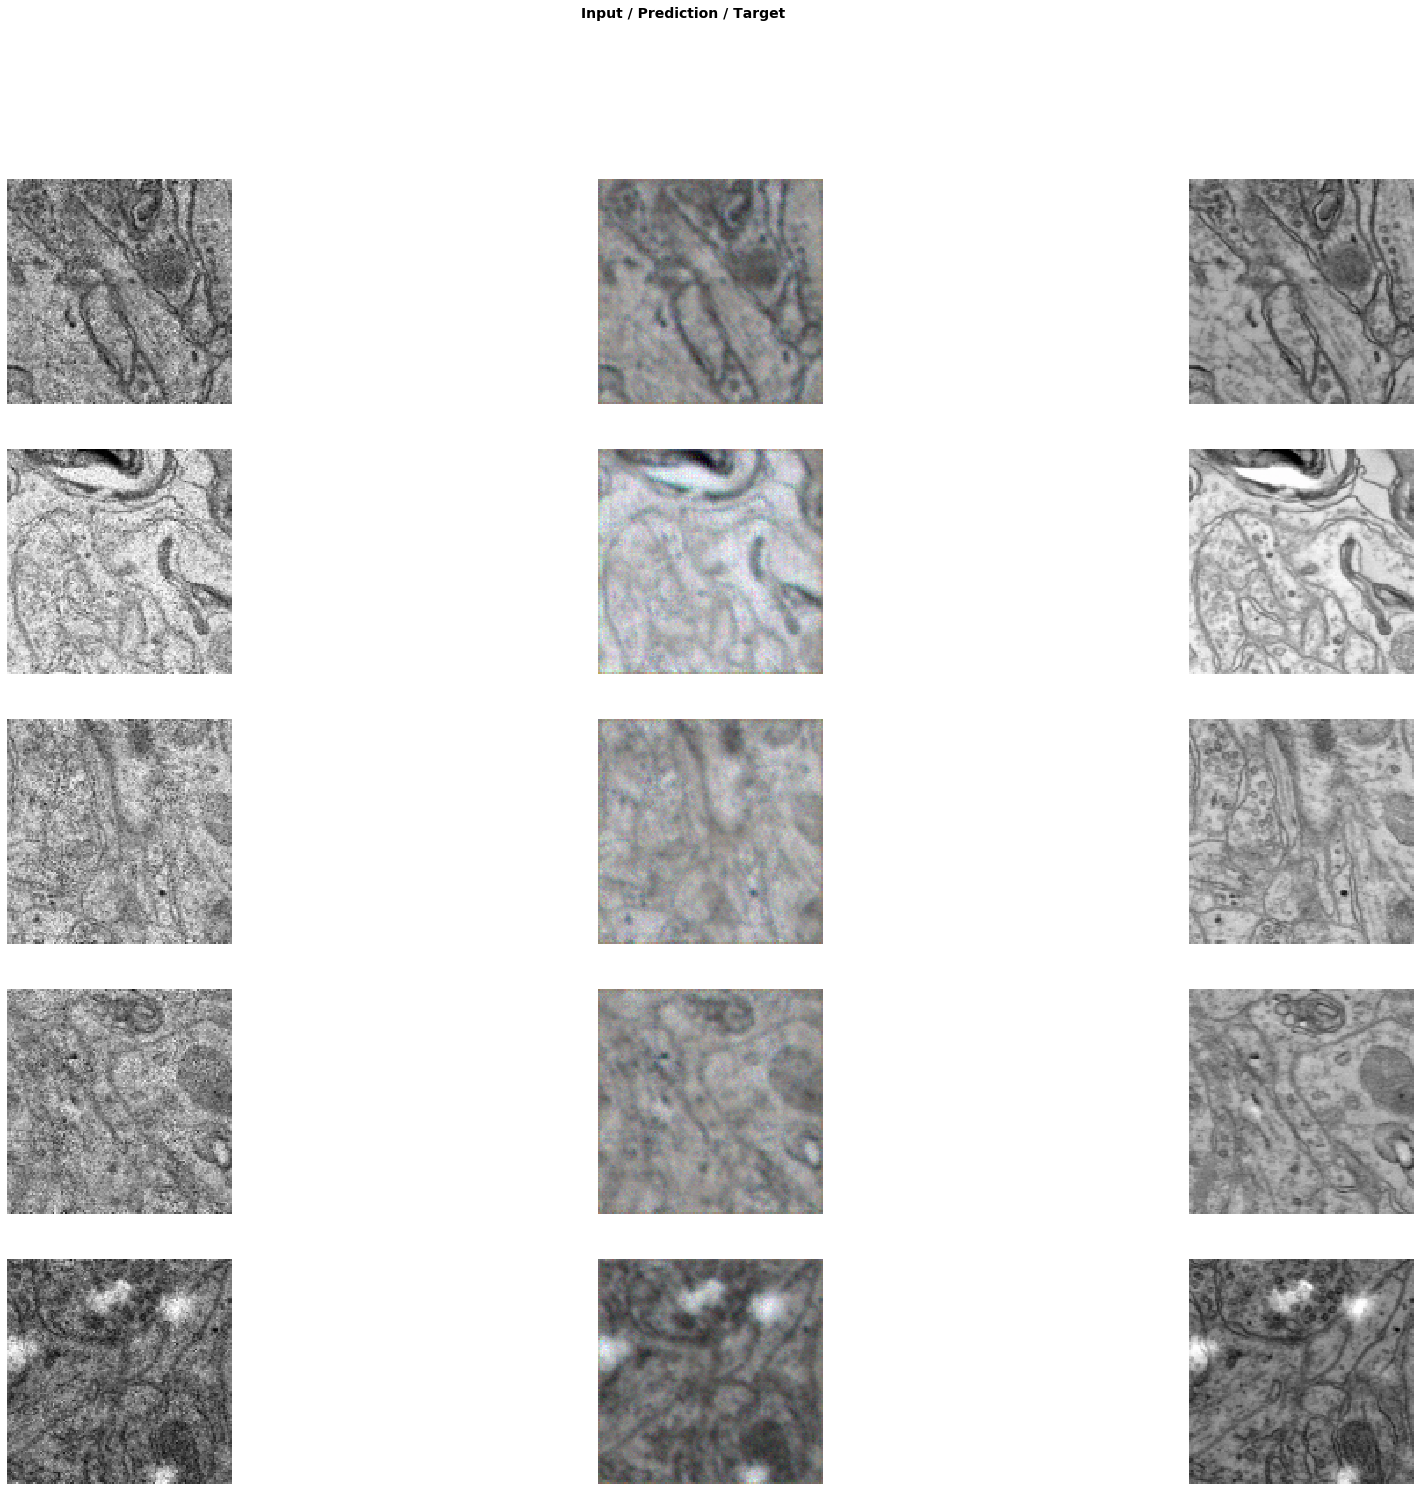

In [21]:
learn.show_results(rows=5, figsize=(30,24))

In [22]:
len(learn.data.valid_dl)

32

### 1b
Unfreeze + MSE

In [23]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


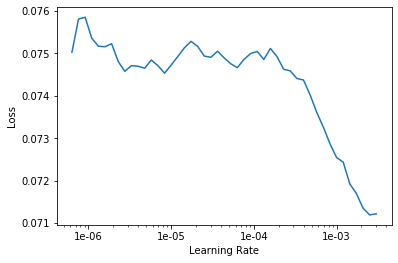

In [25]:
learn.recorder.plot()

In [26]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

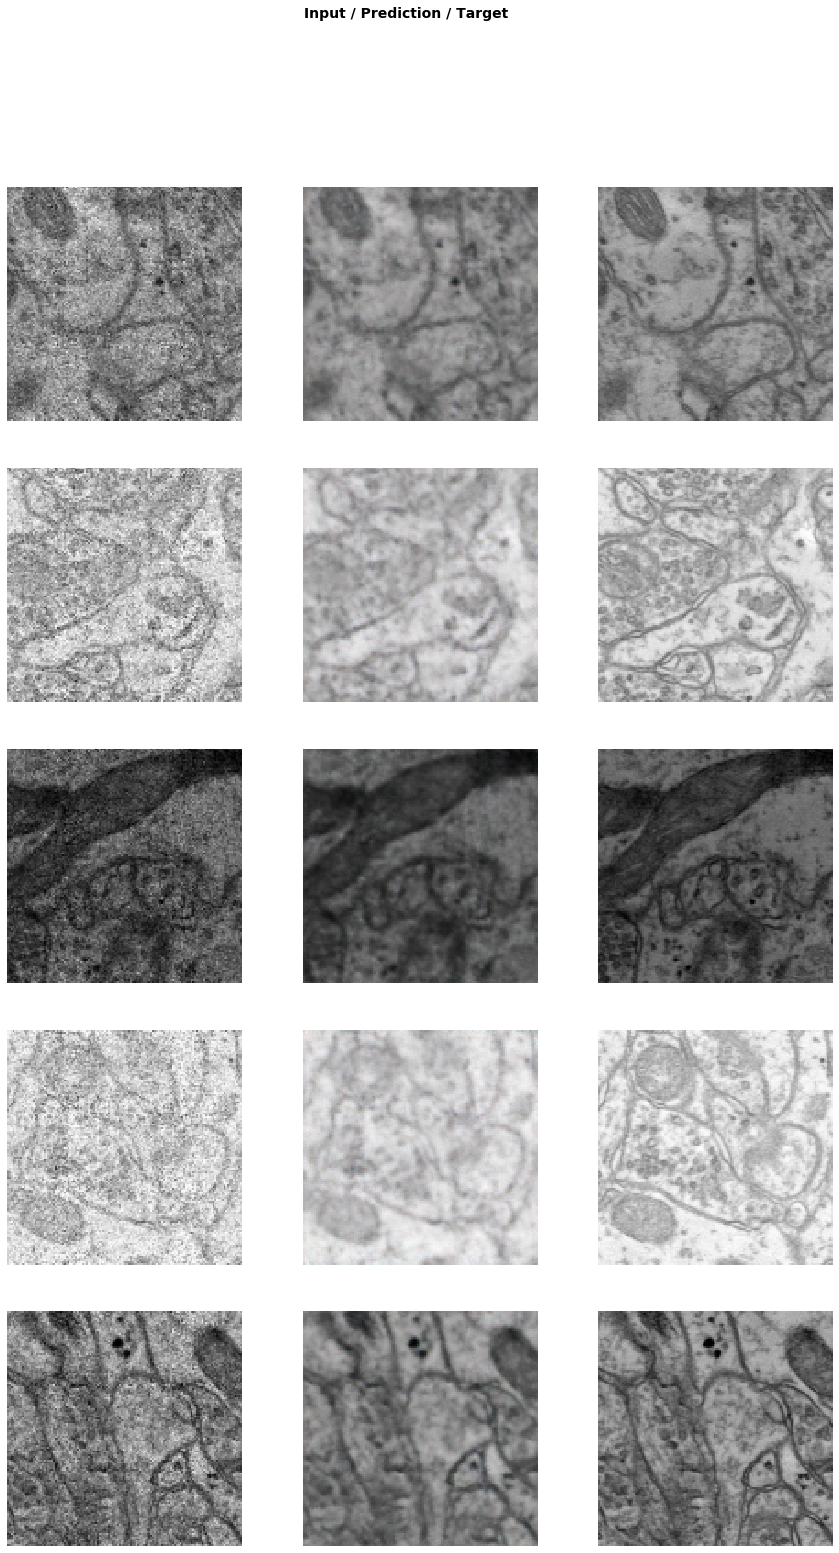

In [27]:
learn.show_results(rows=5, figsize=(15, 25))

## 2a
Freeze + MSE

In [28]:
# loading 3 rounds of data
bs_2 = 32
size_2 = 256
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_2, in_sz=size_2, out_sz=size_2, max_zoom=3)
db = subsample(db, seed=42)

In [29]:
learn.data = db

In [30]:
learn.freeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


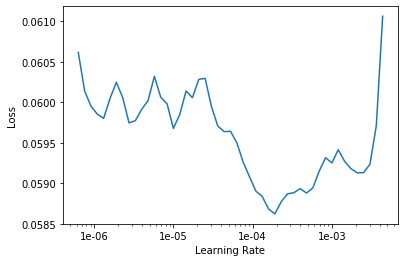

In [32]:
learn.recorder.plot()

In [33]:
lr = 3e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2a', with_opt=False)

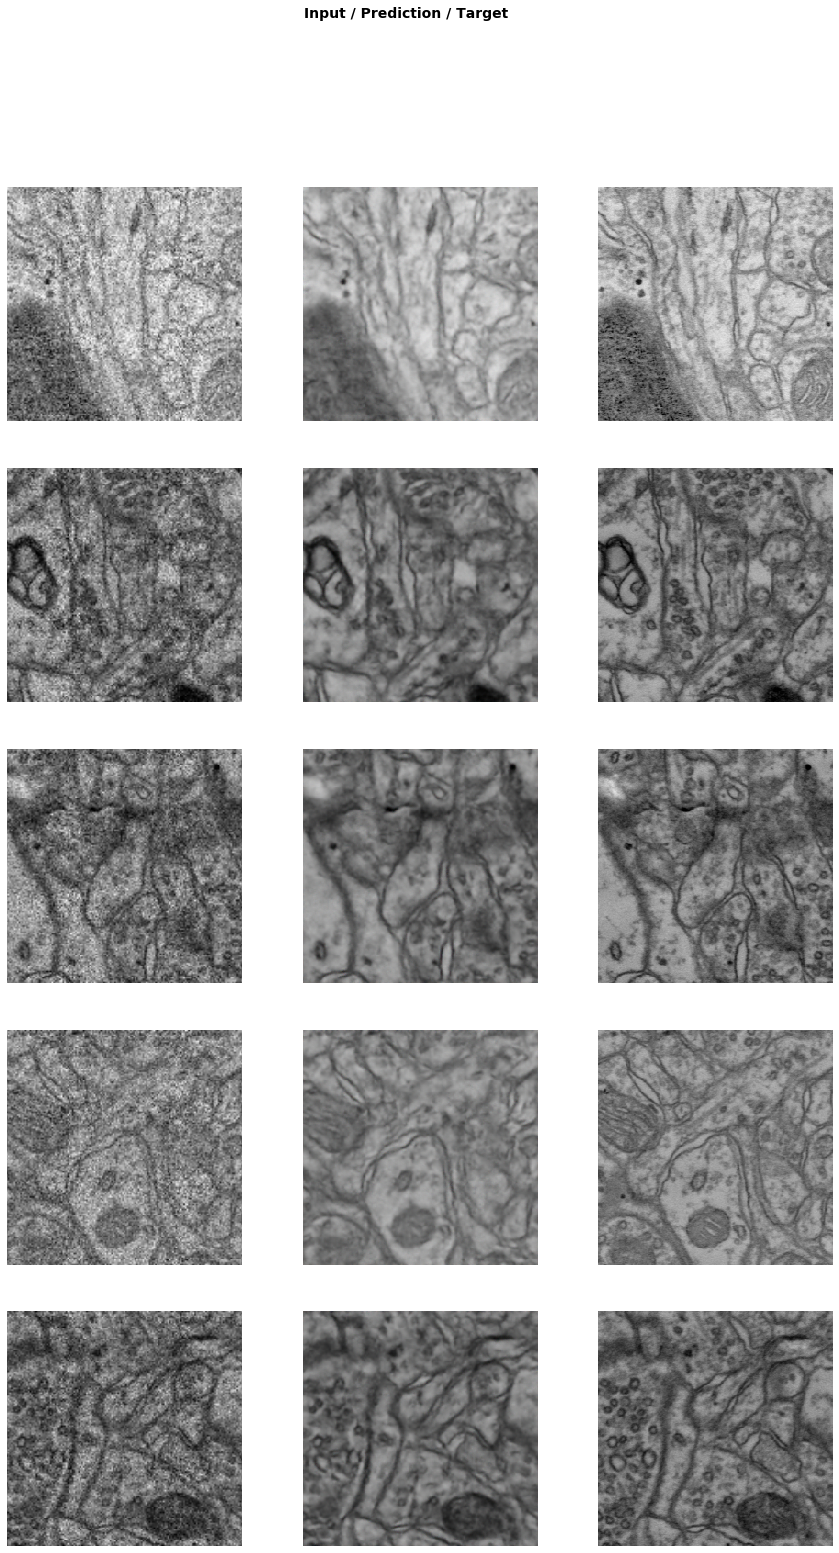

In [34]:
learn.show_results(rows=5, figsize=(15, 25))

## 2b

In [35]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


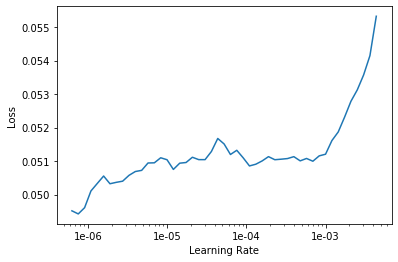

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2b', with_opt=False)

## 3a

In [38]:
# loading 3 rounds of data
bs_3 = 8
size_3 = 512
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_3, in_sz=size_3, out_sz=size_3, max_zoom=1.)
db = subsample(db, seed=42)

In [39]:
learn.data = db
learn.data

ImageDataBunch;

Train: LabelList (79998 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr;

Valid: LabelList (19999 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr;

Test: None

In [40]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


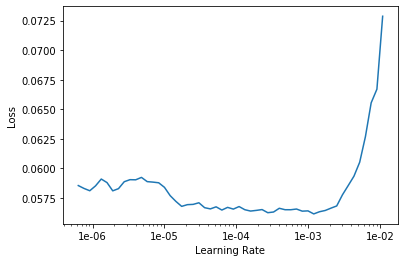

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr = 1e-3
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3a', with_opt=False)

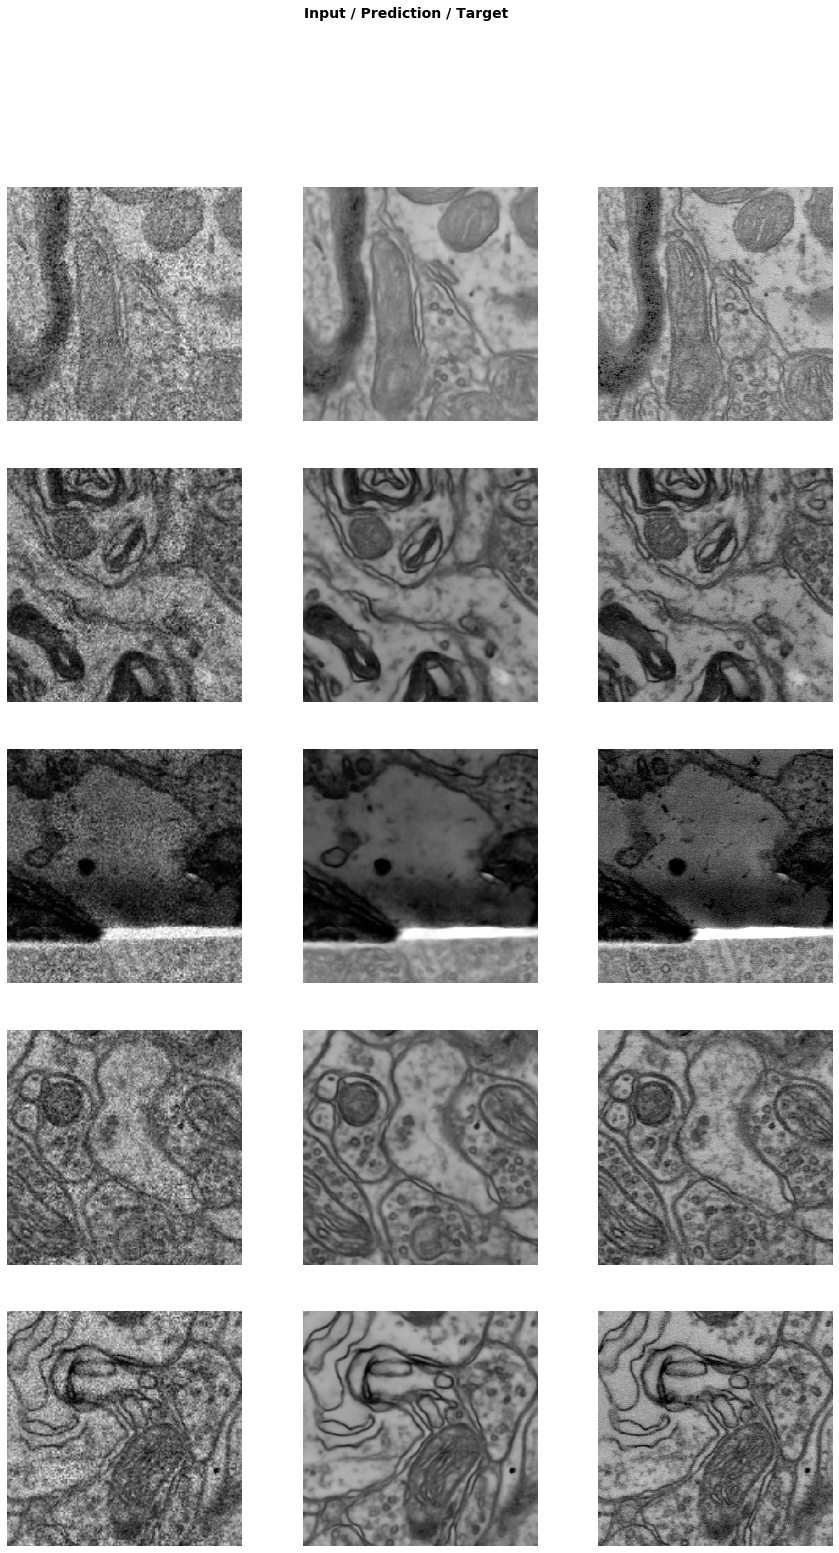

In [43]:
learn.show_results(rows=5, figsize=(15, 25))

In [44]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


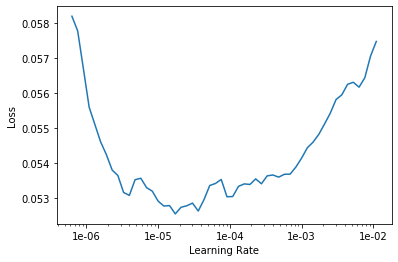

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
lr = slice(3e-5, 3e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3b', with_opt=False)

In [50]:
nb_name

'baseline-pretrained-toddler'

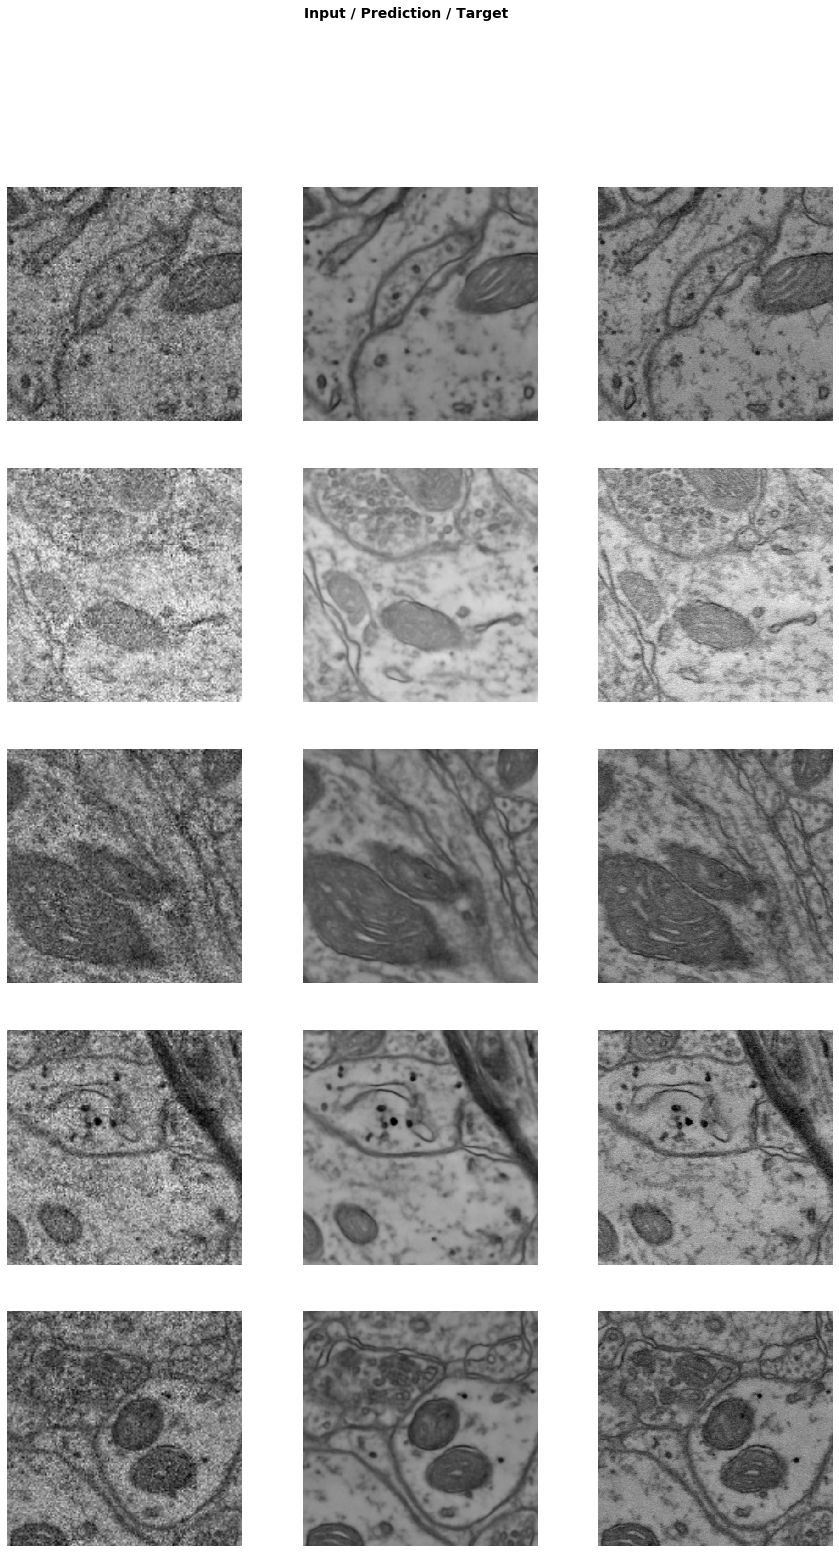

In [47]:
learn.show_results(rows=5, figsize=(15, 25))

In [48]:
# learn.load(f'{nb_name}.3b');

In [49]:
learn.validate()

[0.0523339, tensor(0.0523), tensor(21.1301), tensor(0.2898)]